In [1]:
import os
import torch
import numpy as np
import torch.nn as nn
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import roc_auc_score, classification_report, precision_recall_curve

In [2]:
training_variant = 'smote'  # 'smote' | 'smoteenn' para el otro

if training_variant == 'smote':
    X_train = np.load('./data/X_train_smote.npy')
    y_train = np.load('./data/y_train_smote.npy')
    model_save_path = './models/mlp_smote.pth'
else:
    X_train = np.load('./data/X_train_smoteenn.npy')
    y_train = np.load('./data/y_train_smoteenn.npy')
    model_save_path = './models/mlp_smoteenn.pth'

X_test = np.load("./data/X_test_scaled.npy")
y_test = np.load("./data/y_test.npy")

# Tensores
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)

X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=512, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=512, shuffle=False)

In [3]:
class FocalLoss(nn.Module):
    def __init__(self, alpha=0.25, gamma=2.0, reduction="mean"):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, inputs, targets):
        BCE_loss = F.binary_cross_entropy_with_logits(inputs, targets, reduction="none")
        pt = torch.exp(-BCE_loss)
        loss = self.alpha * (1 - pt) ** self.gamma * BCE_loss

        if self.reduction == "mean":
            return loss.mean()
        elif self.reduction == "sum":
            return loss.sum()
        return loss

In [4]:
class MLP(nn.Module):
  def __init__(self, input_dim):
    super(MLP, self).__init__()
    self.net = nn.Sequential( #? Added
      nn.Linear(input_dim, 256),
      nn.ReLU(),
      nn.BatchNorm1d(256),
      nn.Dropout(0.3),

      nn.Linear(256, 128),
      nn.ReLU(),
      nn.BatchNorm1d(128),
      nn.Dropout(0.3),

      nn.Linear(128, 64),
      nn.ReLU(),
      nn.BatchNorm1d(64),
      nn.Dropout(0.3),

      nn.Linear(64, 1)
    )
  def forward(self, x):
    return self.net(x).squeeze(1)

In [5]:
def train_model(model, loss_fn, optimizer, n_epochs=20, patience=3): #? Changing in test
  model.train()
  best_loss = float('inf') #? Added
  wait = 0
  history = []

  for epoch in range(n_epochs):
    total_loss = 0
    for X_batch, y_batch in train_loader:
      optimizer.zero_grad()
      outputs = model(X_batch)
      loss = loss_fn(outputs, y_batch)
      loss.backward()
      optimizer.step()
      total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)
    history.append(avg_loss)
    print(f"Epoch {epoch+1}/{n_epochs} - Loss: {avg_loss:.4f}")

    if avg_loss < best_loss - 1e-4: #? Added
      best_loss = avg_loss 
      wait = 0
    else:
      wait += 1
      if wait >= patience:
        print("Early stopping")
        break
  return history

In [6]:
input_dim = X_train.shape[1]
model = MLP(input_dim)

loss_fn = FocalLoss(alpha=0.25, gamma=2)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

history = train_model(model, loss_fn, optimizer, n_epochs=20)

# Mas perdida por que detecta mas casos en el proceso de entramiento debido al smote

Epoch 1/20 - Loss: 0.0213
Epoch 2/20 - Loss: 0.0173
Epoch 3/20 - Loss: 0.0157
Epoch 4/20 - Loss: 0.0147
Epoch 5/20 - Loss: 0.0139
Epoch 6/20 - Loss: 0.0133
Epoch 7/20 - Loss: 0.0129
Epoch 8/20 - Loss: 0.0125
Epoch 9/20 - Loss: 0.0122
Epoch 10/20 - Loss: 0.0119
Epoch 11/20 - Loss: 0.0117
Epoch 12/20 - Loss: 0.0115
Epoch 13/20 - Loss: 0.0114
Epoch 14/20 - Loss: 0.0112
Epoch 15/20 - Loss: 0.0111
Epoch 16/20 - Loss: 0.0110
Epoch 17/20 - Loss: 0.0109
Epoch 18/20 - Loss: 0.0108
Epoch 19/20 - Loss: 0.0107
Epoch 20/20 - Loss: 0.0106


In [7]:
model.eval()
with torch.no_grad():
  y_pred_logits = model(X_test_tensor)
  y_pred = torch.sigmoid(y_pred_logits).cpu().numpy() #? Changed if using c|uda
  
  #? Added in this test
  precisions, recalls, thresholds = precision_recall_curve(y_test, y_pred)
  f1s = 2 * (precisions * recalls) / (precisions + recalls + 1e-8)
  best_hreshold = thresholds[np.argmax(f1s)]
  threshold = best_hreshold

  y_pred_labels = (y_pred >= best_hreshold).astype(int)

print(classification_report(y_test, y_pred_labels, digits=4))
print("AUC:", roc_auc_score(y_test, y_pred))

              precision    recall  f1-score   support

           0     0.9910    0.9902    0.9906    239020
           1     0.1766    0.1904    0.1833      2652

    accuracy                         0.9814    241672
   macro avg     0.5838    0.5903    0.5869    241672
weighted avg     0.9821    0.9814    0.9817    241672

AUC: 0.8418330093924247


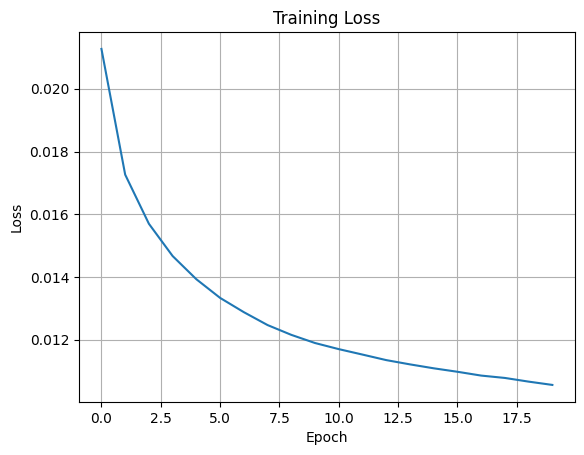

In [8]:
plt.plot(history)
plt.title("Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.show()
os.makedirs("./plots", exist_ok=True)
plt.show()

In [9]:
os.makedirs("./models", exist_ok=True)
torch.save(model.state_dict(), model_save_path)